dataset:

---

https://github.com/liaopeiyuan/artbench

# Import of libraries, creation of the experiment

In [ ]:
# mlflow dependencies
!pip install mlflow pyngrok --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.8/25.8 MB 55.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 58.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 681.8/681.8 kB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.0/120.0 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.6/201.6 kB 16.7 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
# add flag force_remount=True if you changed or added util files
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# common utils for training functions
# change the path to google drive if elsewhere.
# this copies all of the utils file from drive to separate folder
# if this does not work you can always add functions manualy

import sys
if '/content/utils' not in sys.path:
  sys.path.insert(0, '/content/utils')

!cp -r '/content/drive/My Drive/Colab Notebooks/utils' '/content'

In [ ]:
# load mlflow.db from the google drive, so experiments will be present, but without any artifacts
!cp  /content/drive/My\ Drive/Colab\ Notebooks/mlflow_data/mlruns.db  /content/mlruns.db

In [ ]:
!ls '/content'

drive  mlruns.db  sample_data  utils


In [ ]:
from artworks_helpers import *
from fastai_utils import *
from mlflow_utils import *

In [ ]:
LOCAL_REGISTRY = "sqlite:///mlruns.db"
EXPERIMENT_NAME = "Artworks Classification"
MLFLOW_PORT = 5000

In [ ]:
mlfclient = create_mlflow_client(LOCAL_REGISTRY)

2025/08/09 17:35:17 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/08/09 17:35:17 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


In [ ]:
experiment_tags = {
    "dataset": "artbench",
    "link": "https://github.com/liaopeiyuan/artbench",
}

In [ ]:
active_experiment_id = get_mlflow_experiment(mlfclient, EXPERIMENT_NAME, experiment_tags=experiment_tags)

In [ ]:
active_experiment_id

'1'

# Preparation of reduced dataset, where paintings by artists in multiple genres are removed

In [ ]:
from fastai.vision.all import *

In [ ]:
path = untar_data('https://artbench.eecs.berkeley.edu/files/artbench-10-imagefolder-split.tar', data='/content/artbench-reduced')

In [ ]:
import os

In [ ]:
df_original = pd.read_csv("https://artbench.eecs.berkeley.edu/files/ArtBench-10.csv")

In [ ]:
artist_by_number_of_genres   = df_original.groupby('artist')['label'].nunique().reset_index(name='genres_count').sort_values(by='genres_count', ascending=False)
artists_with_multiple_genres = artist_by_number_of_genres[artist_by_number_of_genres['genres_count'] > 1]

In [ ]:
mask = df_original['artist'].isin(artists_with_multiple_genres['artist'].values)
df_original['multiple_genres'] = False
df_original.loc[mask, 'multiple_genres']  = True

Remove files in the download folder where artist occur accross genres

In [ ]:
for _, row in (df_original[df_original['multiple_genres'] == True]).iterrows():
    file_path = path / row['split'] / row['label'] / row['name']
    if file_path.exists():
      os.remove(file_path)

In [ ]:
df = df_original.drop(df_original[df_original['multiple_genres']== True].index)
df.drop(columns=['multiple_genres'], inplace=True)

**Certain genres now have less records, need to change the data split then**

In [ ]:
df_original[df_original['split'] == 'train'].shape[0], df_original[df_original['split'] == 'test'].shape[0]

(50000, 10000)

In [ ]:
df[df['split'] == 'train'].shape[0], df[df['split'] == 'test'].shape[0]

(32878, 6650)

In [ ]:
df[df['split'] == 'train'].groupby('label').size().reset_index(name='count').sort_values(by='count', ascending=True)

,label,count
3,impressionism,1585
4,post_impressionism,1596
0,art_nouveau,2030
5,realism,2049
2,expressionism,2698
7,romanticism,4012
8,surrealism,4176
6,renaissance,4805
1,baroque,4928
9,ukiyo_e,4999


In [ ]:
df[df['split'] == 'test'].groupby('label').size().reset_index(name='count').sort_values(by='count', ascending=True)

,label,count
4,post_impressionism,281
3,impressionism,324
0,art_nouveau,432
5,realism,456
2,expressionism,552
7,romanticism,823
8,surrealism,846
6,renaissance,953
1,baroque,984
9,ukiyo_e,999


# Preparation of dataloaders, model initalization with learning rate finder

In [ ]:
SPLIT_SEED = 42
VALID_PERCENTAGE = 0.2
BATCH_SIZE = 64

In [ ]:
RESNET18_PRETRAINED = 'resnet18_pretrained'
RESNET34_PRETRAINED = 'resnet34_pretrained'

In [ ]:
params_training_all_runs = {'data_split': 'random',
    'split_seed': SPLIT_SEED,
    'split_valid_pct': VALID_PERCENTAGE,
    'batch_tfms': 'Normalize.from_stats(*imagenet_stats)',
    'batch_size': BATCH_SIZE,
    'dataset_variation': 'reduced_artist_with_one_genre',
}


paintings = DataBlock(blocks = (ImageBlock, CategoryBlock),
                get_items=get_image_files,
                splitter=RandomSplitter(seed=SPLIT_SEED, valid_pct=VALID_PERCENTAGE),
                batch_tfms=[Normalize.from_stats(*imagenet_stats)],
                get_y=parent_label)

dls = paintings.dataloaders(path/"train", bs=BATCH_SIZE)

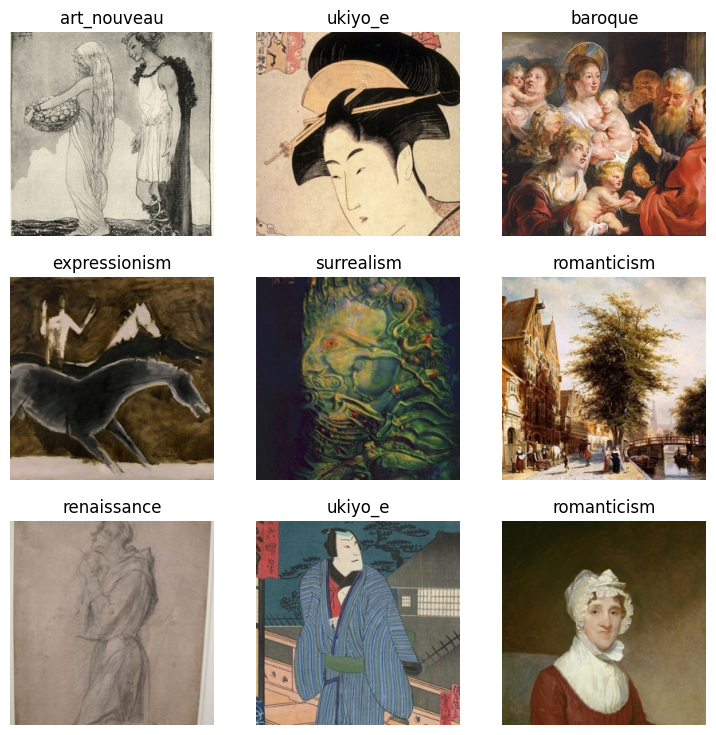

In [ ]:
dls.show_batch()

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
params_training_all_runs['model_name'] = RESNET18_PRETRAINED

{'data_split': 'random', 'split_seed': 42, 'split_valid_pct': 0.2, 'batch_tfms': 'Normalize.from_stats(*imagenet_stats)', 'batch_size': 64, 'dataset_variation': 'reduced_artist_with_one_genre', 'model_name': 'resnet18_pretrained'}

metric: steep,  learning_rate:  0.001202
learning rate when the slope is the steepest, 
loss is decreasing most rapidly

metric: valley,  learning_rate:  0.001738
learning rate from the longest valley, 
this could be before the loss starts to increase rapidly

metric: slide,  learning_rate:  0.002512
learning rate following an interval slide rule, 
this could be when loss is decreasing just before the loss starts to increase rapidly

metric: minimum,  learning_rate:  0.010000
1/10th of the minimum point for the loss function, 
largest sensible value to use for learning rate, since minimum is to high



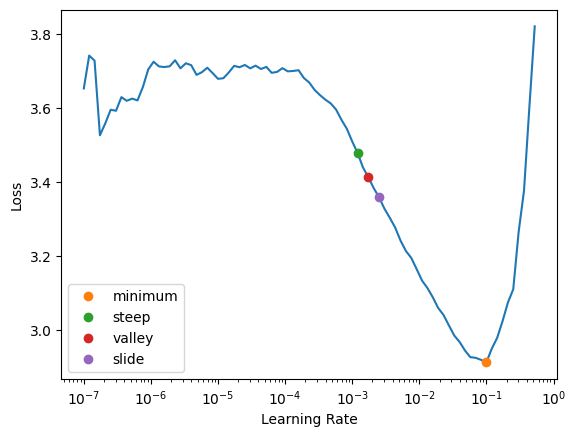

In [ ]:
learn_rate = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
print(params_training_all_runs)
print()
format_lrs(learn_rate)

# Experiment

In [ ]:
with mlflow.start_run(experiment_id=active_experiment_id, run_name='014_resnet18_reduced_dates') as run:

    log_mlflow_params(mlfclient, run, params_training_all_runs)

    run_params = {"learning_rate": 0.005, 'num_epochs': 30, 'pct_start': 0.4, 'div':25, 'div_final':1e5}
    log_mlflow_params(mlfclient, run, run_params)

    cb_mlflow = MLFlowTracking(metric_names=['valid_loss', 'train_loss', 'error_rate'], client=mlfclient, run_id=run.info.run_id)

    learn.freeze()
    learn.fit_one_cycle(run_params['num_epochs'], lr_max=slice(run_params['learning_rate']), pct_start=run_params['pct_start'], div=run_params['div'], div_final=run_params['div_final'], cbs=[cb_mlflow])

    save_fastai_model_as_artifact(mlfclient, run.info.run_id, learn, 'fastai_resnet18_train_only_frozen.pkl')

epoch,train_loss,valid_loss,error_rate,time
0,1.621108,1.200741,0.411407,01:26
1,1.370798,1.094912,0.383726,01:21
2,1.171881,1.029000,0.368213,01:22
3,1.140399,0.999554,0.362281,01:22
4,1.074291,0.978182,0.354068,01:22
5,1.056651,0.966824,0.351787,01:21
6,0.996810,0.939327,0.339772,01:22
7,0.967103,0.934838,0.335817,01:20
8,0.915953,0.916733,0.330038,01:22
9,0.910887,0.892859,0.321673,01:22


artifact_uri saved as model
runs:/0dcd6ca993ba4a4389bcaae817b2e278/fastai_model/fastai_resnet18_train_only_frozen.pkl


In [ ]:
run = get_last_run_id(mlfclient, '1')

In [ ]:
import pickle

def store_train_recordings(learn, run, genres_sorted_era):
  # save loss recording plot
  loss_plot_path = "loss_plot.png"
  learn.recorder.plot_loss(show_epochs=True).figure.savefig(loss_plot_path)
  mlfclient.log_artifact(run.info.run_id, local_path=loss_plot_path,
          artifact_path='figures')

  interp = ClassificationInterpretation.from_learner(learn)
  add_methods_to_interpetation(interp)

  # save confussion matrix image
  interp.plot_confusion_matrix_vocab(genres_sorted_era, figsize=(12,12), dpi=60).figure.savefig('confussion_matrix')
  mlfclient.log_artifact(run.info.run_id, local_path='confussion_matrix.png',
          artifact_path='figures' )

  # save interpretation object
  interp_path = "interpretation.pkl"
  with open(interp_path, "wb") as f:
      pickle.dump(interp, f)

  # Log the interpretation object as an artifact to the current MLflow run
  mlfclient.log_artifact(run.info.run_id, local_path=interp_path,
          artifact_path='interpetation' )


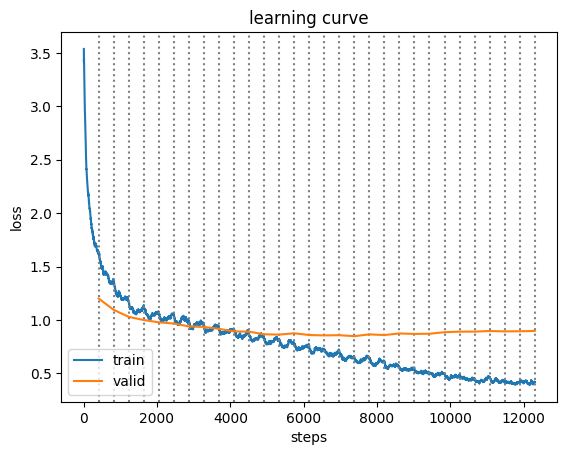

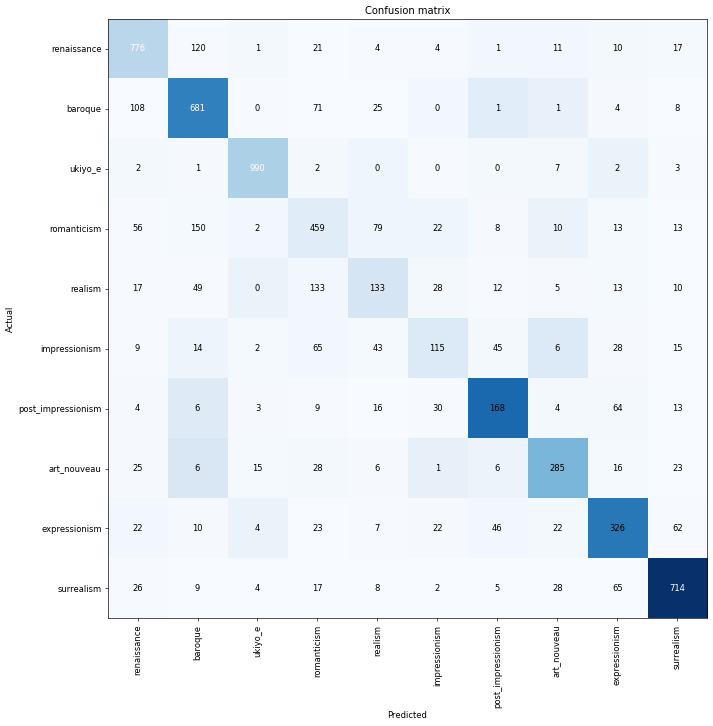

In [ ]:
store_train_recordings(learn, run, genres_sorted_era)

In [ ]:
# copy mlflow mlruns.db back to server
!cp   /content/mlruns.db  /content/drive/My\ Drive/Colab\ Notebooks/mlflow_data/mlruns.db

# copy mlflow_data back to server
!cp -r /content/mlruns    /content/drive/My\ Drive/Colab\ Notebooks/mlflow_data

# Interpretation of the results, in comparison with experiments on whole dataset

**Results from experiment 014**

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
interp.print_classification_report()

                    precision    recall  f1-score   support

       art_nouveau       0.75      0.69      0.72       411
           baroque       0.65      0.76      0.70       899
     expressionism       0.60      0.60      0.60       544
     impressionism       0.51      0.34      0.41       342
post_impressionism       0.58      0.53      0.55       317
           realism       0.41      0.33      0.37       400
       renaissance       0.74      0.80      0.77       965
       romanticism       0.55      0.57      0.56       812
        surrealism       0.81      0.81      0.81       878
           ukiyo_e       0.97      0.98      0.98      1007

          accuracy                           0.71      6575
         macro avg       0.66      0.64      0.65      6575
      weighted avg       0.70      0.71      0.70      6575



In [ ]:
def distance(list_of_elems, el1, el2):
  return abs(list_of_elems.index(el1) - list_of_elems.index(el2))


In [ ]:
distance_formula = partial(distance, genres_sorted_era)
confused_counts = interp.most_confused()

In [ ]:
for count in confused_counts:
    print((count[0], count[1],  distance_formula(count[0], count[1]), count[2]))

('romanticism', 'baroque', 2, np.int64(150))
('realism', 'romanticism', 1, np.int64(133))
('renaissance', 'baroque', 1, np.int64(120))
('baroque', 'renaissance', 1, np.int64(108))
('romanticism', 'realism', 1, np.int64(79))
('baroque', 'romanticism', 2, np.int64(71))
('impressionism', 'romanticism', 2, np.int64(65))
('surrealism', 'expressionism', 1, np.int64(65))
('post_impressionism', 'expressionism', 2, np.int64(64))
('expressionism', 'surrealism', 1, np.int64(62))
('romanticism', 'renaissance', 3, np.int64(56))
('realism', 'baroque', 3, np.int64(49))
('expressionism', 'post_impressionism', 2, np.int64(46))
('impressionism', 'post_impressionism', 1, np.int64(45))
('impressionism', 'realism', 1, np.int64(43))
('post_impressionism', 'impressionism', 1, np.int64(30))
('art_nouveau', 'romanticism', 4, np.int64(28))
('impressionism', 'expressionism', 3, np.int64(28))
('realism', 'impressionism', 1, np.int64(28))
('surrealism', 'art_nouveau', 2, np.int64(28))
('surrealism', 'renaissance',